# Load libraries

In [1]:
# %matplotlib inline

import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt
import glob

from tensorflow import keras
# import keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.applications.imagenet_utils import preprocess_input

from sklearn.metrics import confusion_matrix

In [2]:
# tf.config.list_physical_devices()
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# CONFIG

In [3]:
# Hyperparameters
epochs = 200
step_size = 5
gamma = 0.1 # drop rate 
batch_size = 64
img_size = 44
learning_rate = 1e-2
momentum = 0.9
start_lr_decay = 70

checkpoint_filepath = f"./weights/onion/edgecnn_inpsize{img_size}_batch{batch_size}_epochs{epochs}__adam_20221118.hdf5"
name = checkpoint_filepath.split('/')[-1].split('.')[0]
tflite_model_path = f"./tflite_weights/onion/{name}.tflite"

# Data generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'data/onion/'

IMG_SIZE = img_size
batch_size_train = batch_size
batch_size_valid = batch_size

with tf.device('/device:GPU:0'):
    train_datagen = ImageDataGenerator(
                        brightness_range=[0.5,1.5],
                        channel_shift_range=100.0,
                        zoom_range=[0.5, 1.5],
                        horizontal_flip=True,
                        vertical_flip=True,
                        # preprocessing_function=preprocess_input,   
                    )    

    test_datagen = ImageDataGenerator(
                                # preprocessing_function=preprocess_input
                            )

    train_generator = train_datagen.flow_from_directory(
        base_dir+"train/",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size_train,
        class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
        base_dir + "valid/",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size_valid,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        base_dir + "test/",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size_valid,
        class_mode='categorical',
        shuffle = False)
        
steps_epoch = len(train_generator)
valid_steps = len(validation_generator)
print(steps_epoch, valid_steps)

Found 1395 images belonging to 3 classes.
Found 385 images belonging to 3 classes.
Found 220 images belonging to 3 classes.
22 7


In [5]:
print(train_generator[0][0].shape)
print(train_generator.num_classes)
print(np.max(train_generator[0][0][0]))
print(np.min(train_generator[0][0][0]))

(64, 44, 44, 3)
3
184.0
0.0


# Model

In [6]:
from model.edgecnn import EdgeCNN
# from keras.optimizers import SGD


with tf.device('/device:GPU:0'):        
    rescale_layer = tf.keras.layers.Rescaling(1./225)
    edge_cnn = EdgeCNN(growth_rate=8, input_shape=(44,44,3), classes=3)

    inputs = tf.keras.Input(shape=(44, 44, 3))
    x = rescale_layer(inputs)
    outputs = edge_cnn(x)
    model = tf.keras.Model([inputs], [outputs])

    # optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum) # , nesterov=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [7]:
import math
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, 
                               verbose=1, save_best_only=True)

# lr drops after 80 epochs, every STEP_SIZE epochs
def lr_step_decay(epoch, lr):
    if lr < 1e-10:
        lr = learning_rate
        return lr
    drop_rate = gamma
    epochs_drop = step_size
    if epoch > start_lr_decay:
        if epoch % step_size == 0:
            return (lr * drop_rate)
    return lr

callbacks_list = [checkpointer,
                  LearningRateScheduler(lr_step_decay, verbose=1)]


# Independent training

In [8]:
history = model.fit(
    train_generator,
    shuffle = True,
    steps_per_epoch=steps_epoch,
    epochs=epochs,
    callbacks= callbacks_list,
    validation_data=validation_generator,
    validation_steps=valid_steps,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/200
22/22 [==============================] - ETA: 0s - loss: 5.3999 - categorical_accuracy: 0.3878
Epoch 1: val_loss improved from inf to 5849348.00000, saving model to ./weights/onion\edgecnn_inpsize44_batch64_epochs200__adam_20221118.hdf5
22/22 [==============================] - 50s 2s/step - loss: 5.3999 - categorical_accuracy: 0.3878 - val_loss: 5849348.0000 - val_categorical_accuracy: 0.3766 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/200
22/22 [==============================] - ETA: 0s - loss: 4.5864 - categorical_accuracy: 0.4323
Epoch 2: val_loss improved from 5849348.00000 to 511.92532, saving model to ./weights/onion\edgecnn_inpsize44_batch64_epochs200__adam_20221118.hdf5
22/22 [==============================] - 38s 2s/step - loss: 4.5864 - categorical_accuracy: 0.4323 - val_loss: 511.9253 - val_categorical_accuracy: 0.3714 - lr: 0.010

## To continue training from checkpoint

In [9]:
# ongoing_model = tf.keras.models.load_model(checkpoint_filepath)
# ongoing_model.evaluate(validation_generator)

# epochs = epochs
# learning_rate = 1e-2
# history = ongoing_model.fit(
#     train_generator,
#     shuffle = True,
#     steps_per_epoch=steps_epoch,
#     epochs=epochs,
#     callbacks = callbacks_list,
#     validation_data=validation_generator,
#     validation_steps=valid_steps,
#     initial_epoch=85,
#     )

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


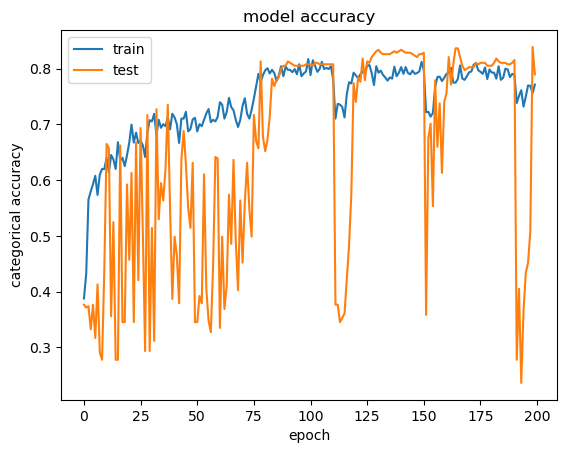

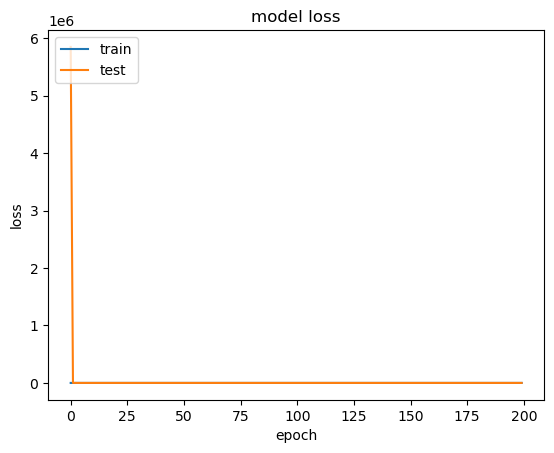

In [10]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# checkpoint = f"./tf_weights/Balanced_data_20221007/resnet18.inpsize{img_size}_batch{batch_size}_epochs{epochs}_ss{step_size}_gamma{gamma}_rescale_model_1"
# model.save(checkpoint)

In [12]:
# Convert the model to tflite
import tensorflow as tf
from tensorflow.keras.models import load_model

model.load_weights(checkpoint_filepath)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(tflite_model_path, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Om\AppData\Local\Temp\tmpz7nk870s\assets


INFO:tensorflow:Assets written to: C:\Users\Om\AppData\Local\Temp\tmpz7nk870s\assets


19952440

In [13]:
# model = tf.keras.models.load_model(checkpoint_filepath)
# model.load_weights(checkpoint_filepath)
# model.load_weights(f"./weights/onion/edgecnn_inpsize{img_size}_batch{64}_epochs{200}_20221116.hdf5")
model.load_weights(checkpoint_filepath)
valid_evaluation = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)  

preds = model.predict(test_generator, verbose=1)
pred_labels = np.argmax(preds,axis=1)

4/4 [==============================] - 5s 1s/step


In [14]:
y_test = []

for i in range(len(test_generator)):
    x, y = next(test_generator)
    y_test.extend(y)

y_test = np.array(y_test).squeeze()
y_true = np.argmax(y_test,1)

# import sys
# np.set_printoptions(threshold = sys.maxsize)
# print(y_test[:10])
# print()
# print(pred_labels[:10])

conf_matrix = confusion_matrix(y_true, pred_labels)
diag_sum = np.diag(conf_matrix).sum()
prediction_acc = diag_sum/conf_matrix.sum()
print("Confusion Matrix:\n", conf_matrix)
print("Prediction Accuracy: ", prediction_acc)

Confusion Matrix:
 [[46 14  0]
 [11 68  2]
 [ 0  7 72]]
Prediction Accuracy:  0.8454545454545455


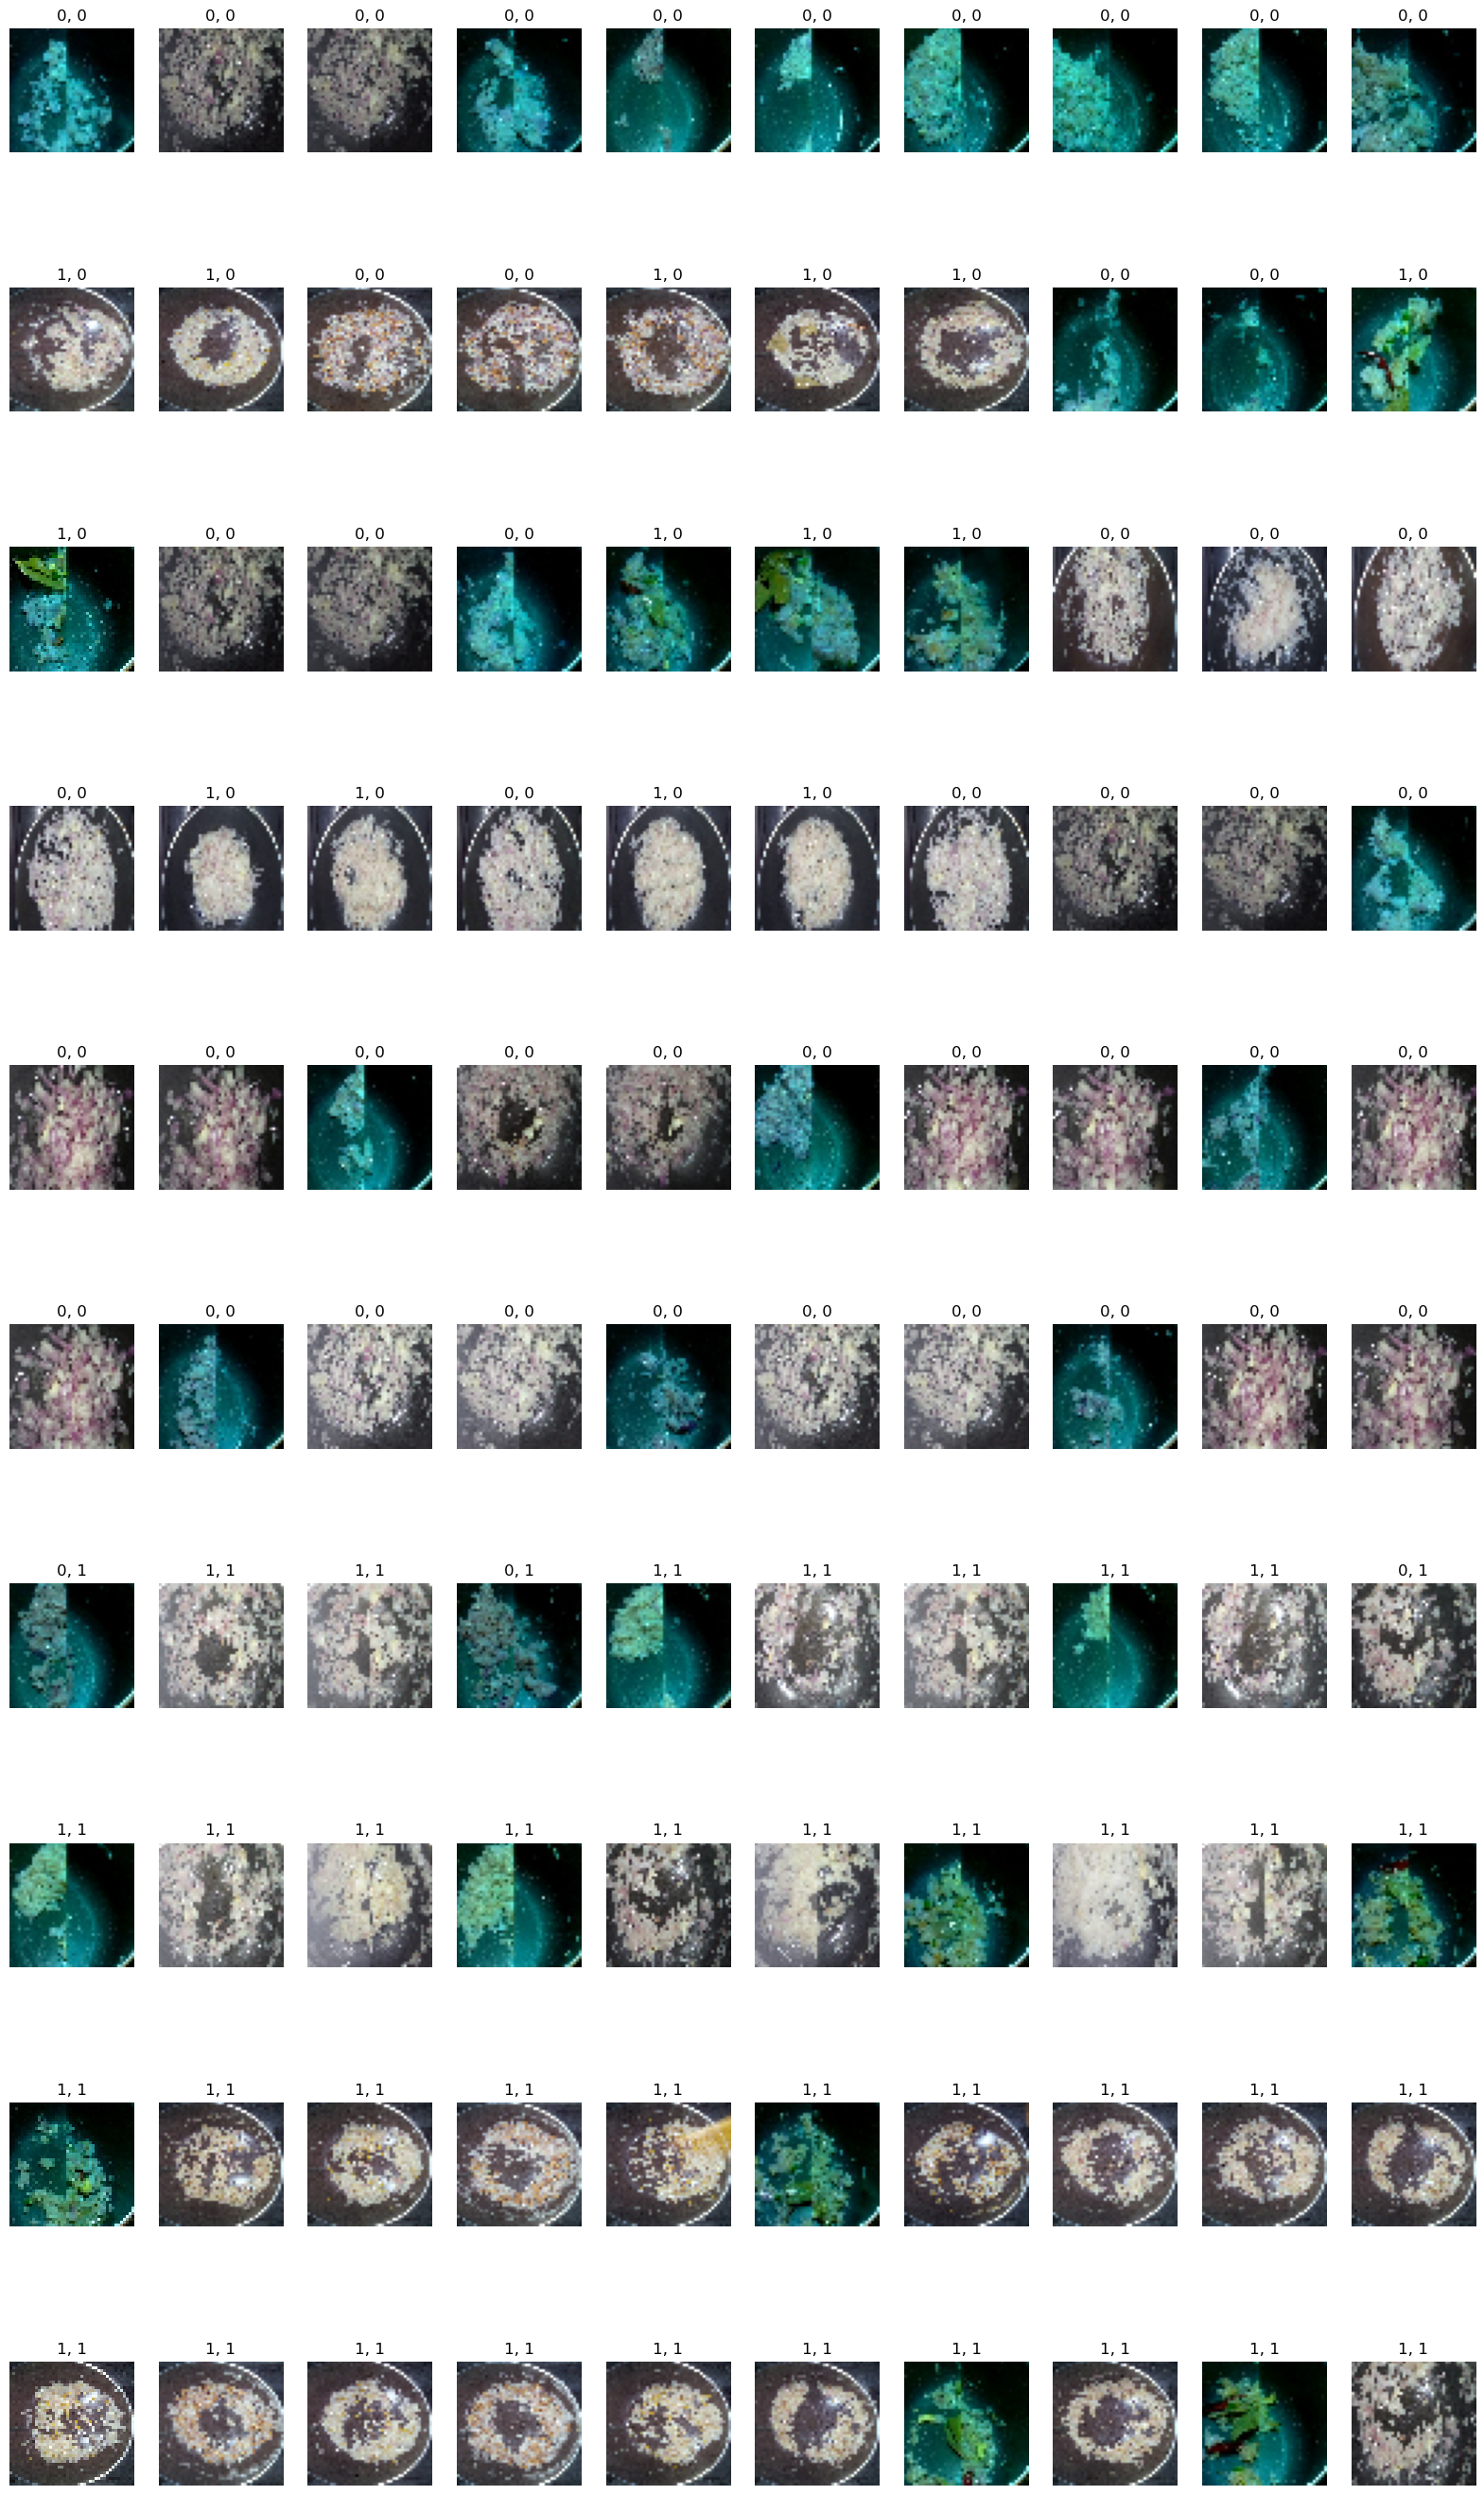

In [15]:
# name = ['Raw', 'Cooked']
name = ['0', '1', '2']

figure = plt.figure(figsize=(20,35))
figure.tight_layout()
for i in range(len(test_generator)):
    imgs, true_label = next(iter(test_generator))
    if i*len(imgs)>99: break
    for j in range(len(imgs)):  
        if j+i*len(imgs)>99: break  
        img = np.array(np.squeeze(imgs[j]), dtype=np.uint8)
        truth = name[np.argmax(true_label[j])]
        index = (i*batch_size_valid)+j
        plt.subplot(10,10,index+1)
        plt.axis('off')
        plt.title(f'{name[pred_labels[index]]}, {truth}')
        plt.imshow(img)

plt.show()

Testing with other datasets (Just for reference)


In [16]:
# with tf.device('/device:GPU:0'):
    
#     checkpoint_filepath = checkpoint_filepath
#     print(checkpoint_filepath)
#     model1 = load_model(checkpoint_filepath)
#     models = [model1] 

#     other_test_datagen = ImageDataGenerator()

#     base_dir = 'D:/HDD/EuphoticLabs/Tomato_data/Datasets/Aadit_data/Model_4_5/test_train_valid_split/'
#     catg = ['test', 'valid']

#     for model in models:
#         for i in catg:    
#             print()
#             print(i + ' data')
#             test_generator = other_test_datagen.flow_from_directory(
#                 base_dir + i,
#                 target_size=(224, 224),
#                 batch_size=64,
#                 class_mode='categorical',
#                 shuffle=False
#             )

#             preds = model.predict(test_generator, verbose=1)
#             pred_labels = np.argmax(preds,axis=1)

#             # test_score = model.evaluate(test_generator)

#             y_test = []

#             for i in range(len(test_generator)):
#                 x, y = next(test_generator)
#                 y_test.extend(y)

#             y_test = np.array(y_test).squeeze()
#             y_true = np.argmax(y_test,1)

#             conf_matrix = confusion_matrix(y_true, pred_labels)
#             diag_sum = np.diag(conf_matrix).sum()
#             prediction_acc = diag_sum/conf_matrix.sum()
#             print("Confusion Matrix:\n", conf_matrix)
#             print("Prediction Accuracy: ", prediction_acc)